In [0]:
!wget -N https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!wget -N https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
!unzip -o dogImages.zip
!unzip -o lfw.zip

!mv dogImages dog_images

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: lfw/Steffi_Graf/Steffi_Graf_0003.jpg  
  inflating: __MACOSX/lfw/Steffi_Graf/._Steffi_Graf_0003.jpg  
  inflating: lfw/Steffi_Graf/Steffi_Graf_0004.jpg  
  inflating: __MACOSX/lfw/Steffi_Graf/._Steffi_Graf_0004.jpg  
  inflating: lfw/Steffi_Graf/Steffi_Graf_0005.jpg  
  inflating: __MACOSX/lfw/Steffi_Graf/._Steffi_Graf_0005.jpg  
  inflating: __MACOSX/lfw/._Steffi_Graf  
   creating: lfw/Stella_Keitel/
  inflating: lfw/Stella_Keitel/Stella_Keitel_0001.jpg  
   creating: __MACOSX/lfw/Stella_Keitel/
  inflating: __MACOSX/lfw/Stella_Keitel/._Stella_Keitel_0001.jpg  
  inflating: __MACOSX/lfw/._Stella_Keitel  
   creating: lfw/Stella_McCartney/
  inflating: lfw/Stella_McCartney/Stella_McCartney_0001.jpg  
   creating: __MACOSX/lfw/Stella_McCartney/
  inflating: __MACOSX/lfw/Stella_McCartney/._Stella_McCartney_0001.jpg  
  inflating: __MACOSX/lfw/._Stella_McCartney  
   creating: lfw/Stella_Tennant/
  inflating: lfw/S

In [0]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [0]:
import PIL
import numpy as np
import torch
import torchvision

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

def show_dataset(dataset, n=6):
  img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
                   for i in range(n)))
  plt.imshow(img)
  plt.axis('off')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  app.launch_new_instance()


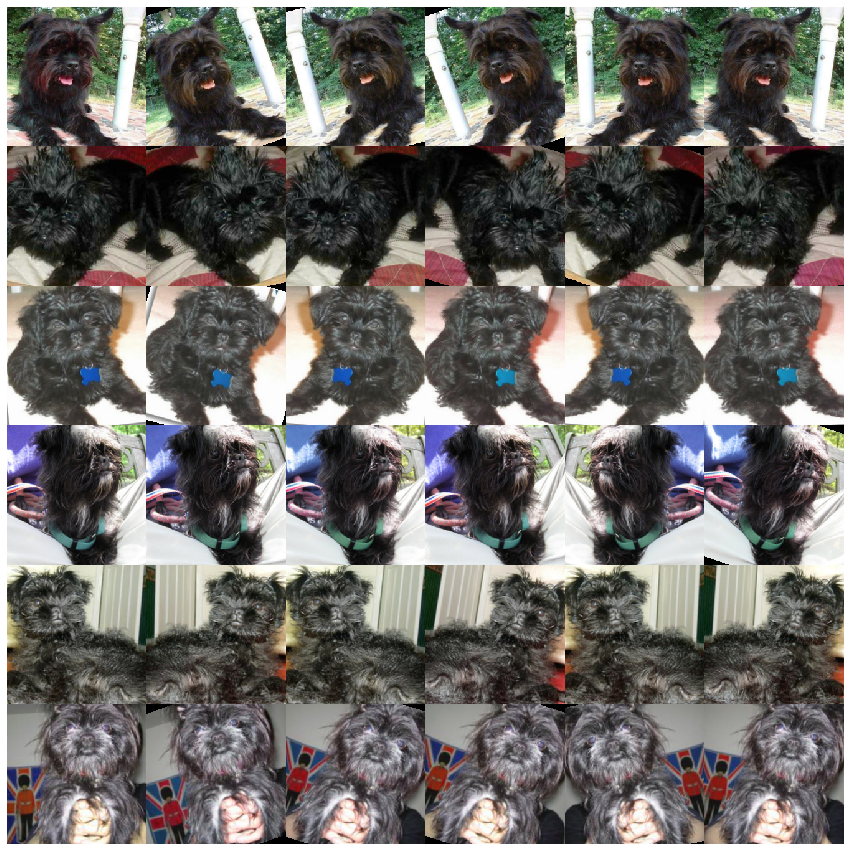

In [0]:
import torchvision.transforms as transforms

train_transforms = transforms.Compose([
                                       transforms.Resize(258),
                                       transforms.ColorJitter(hue=.05, saturation=.05),
                                       transforms.RandomHorizontalFlip(),
                                       torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
                                       transforms.CenterCrop(224)
                                       ])


dataset = torchvision.datasets.ImageFolder('/content/dog_images/train', transform=train_transforms)

show_dataset(dataset)

In [0]:
#!pip install git+https://github.com/aleju/imgaug
from imgaug import augmenters as iaa
import imgaug as ia

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  app.launch_new_instance()


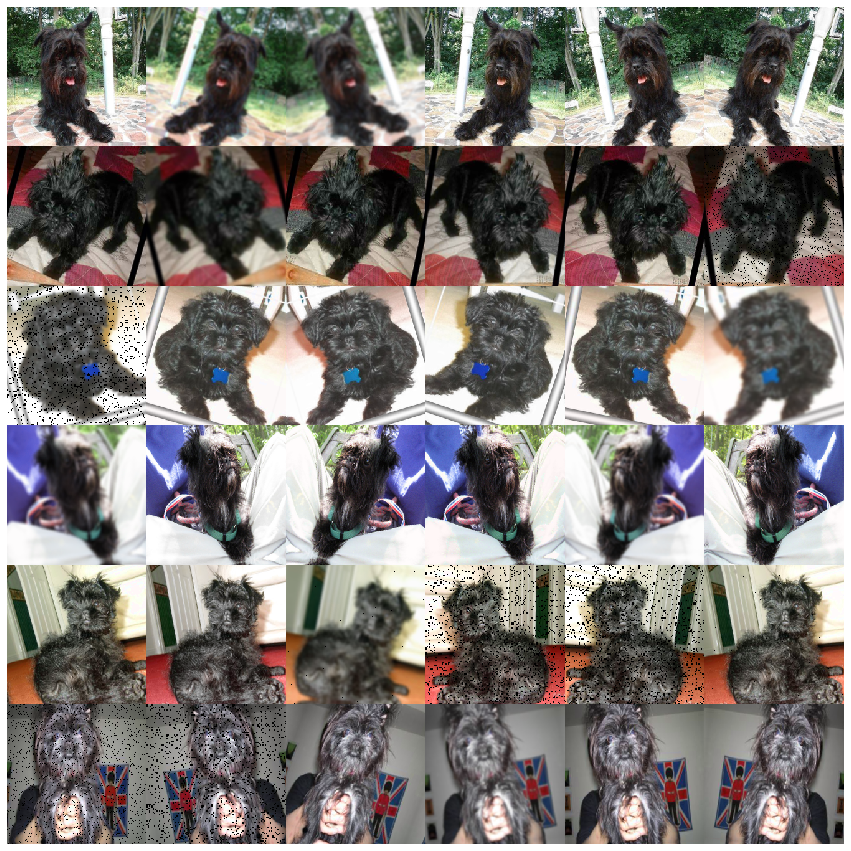

In [0]:
class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Resize((224, 224)),
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)])),
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

transforms = ImgAugTransform()

dataset = torchvision.datasets.ImageFolder('/content/dog_images/train', transform=transforms)

show_dataset(dataset)

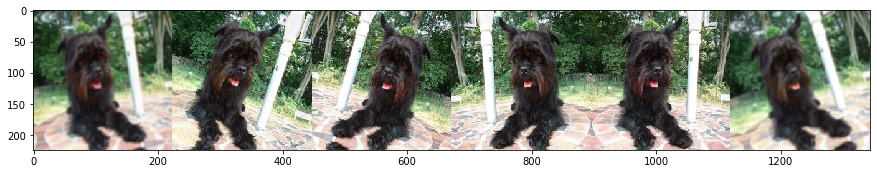

In [0]:
aug = iaa.Affine(rotate=(-40, 40), mode='symmetric')
imgs = [np.asarray(dataset[0][0]) for _ in range(6)]
aug.augment_images(imgs)
plt.imshow(np.hstack(imgs))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  app.launch_new_instance()


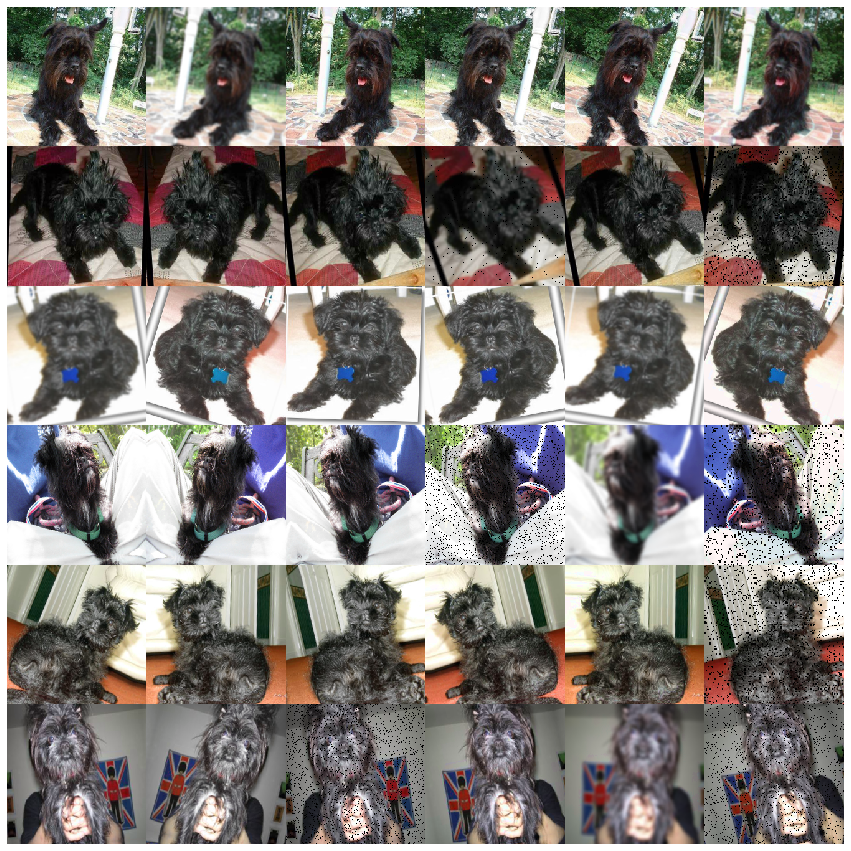

In [0]:


dataset = torchvision.datasets.ImageFolder('/content/dog_images/train', transform=transforms)

show_dataset(dataset)

In [0]:
import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

train_transforms = transforms.Compose([transforms.Resize(size=258),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(10),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

mixed_transforms = torchvision.transforms.Compose([
    ImgAugTransform(),
    lambda x: PIL.Image.fromarray(x),
    torchvision.transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([transforms.Resize(size=258),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder('dog_images/train', transform=mixed_transforms)
valid_data = datasets.ImageFolder('dog_images/valid', transform=valid_transforms)
test_data = datasets.ImageFolder('dog_images/test', transform=valid_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)

validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True, num_workers=4)

testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)

loaders_scratch = {'train' : trainloader, 'valid' : validloader, 'test' : testloader}

In [0]:
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

def class_names(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_names_dict = {i : classes[i] for i in range(len(classes))}
    return class_names_dict

class_names_dict = class_names('dog_images/train')
print(class_names_dict)

{0: '001.Affenpinscher', 1: '002.Afghan_hound', 2: '003.Airedale_terrier', 3: '004.Akita', 4: '005.Alaskan_malamute', 5: '006.American_eskimo_dog', 6: '007.American_foxhound', 7: '008.American_staffordshire_terrier', 8: '009.American_water_spaniel', 9: '010.Anatolian_shepherd_dog', 10: '011.Australian_cattle_dog', 11: '012.Australian_shepherd', 12: '013.Australian_terrier', 13: '014.Basenji', 14: '015.Basset_hound', 15: '016.Beagle', 16: '017.Bearded_collie', 17: '018.Beauceron', 18: '019.Bedlington_terrier', 19: '020.Belgian_malinois', 20: '021.Belgian_sheepdog', 21: '022.Belgian_tervuren', 22: '023.Bernese_mountain_dog', 23: '024.Bichon_frise', 24: '025.Black_and_tan_coonhound', 25: '026.Black_russian_terrier', 26: '027.Bloodhound', 27: '028.Bluetick_coonhound', 28: '029.Border_collie', 29: '030.Border_terrier', 30: '031.Borzoi', 31: '032.Boston_terrier', 32: '033.Bouvier_des_flandres', 33: '034.Boxer', 34: '035.Boykin_spaniel', 35: '036.Briard', 36: '037.Brittany', 37: '038.Brussels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


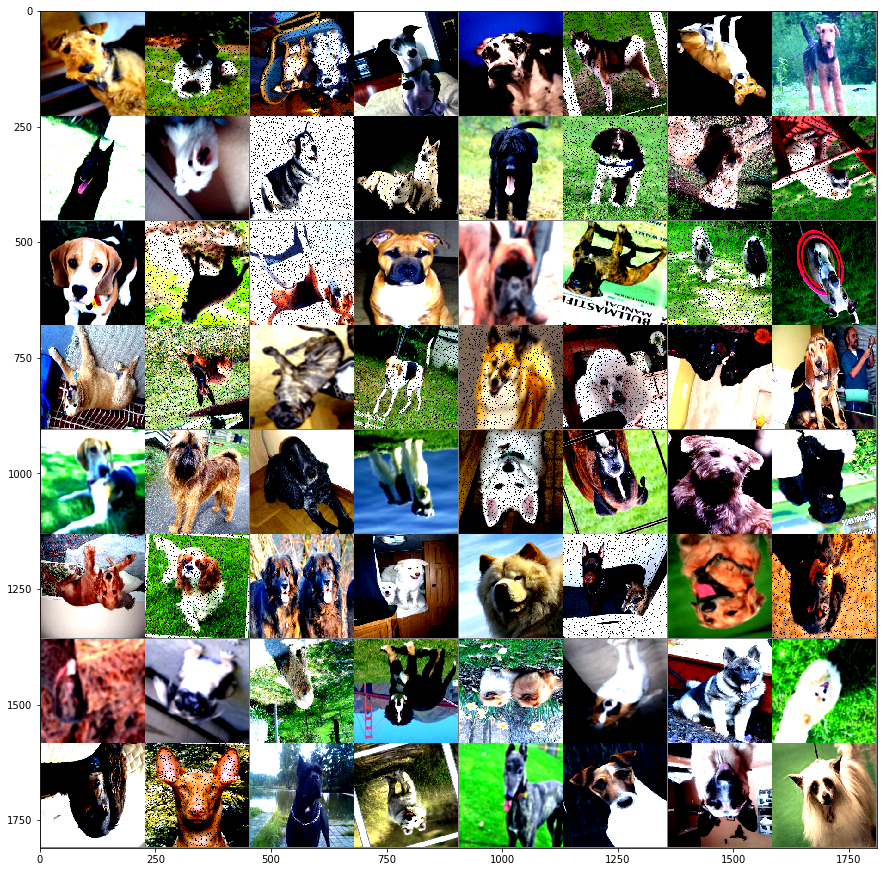

003.Airedale_terrier 122.Pointer 053.Cocker_spaniel 090.Italian_greyhound 078.Great_dane 005.Alaskan_malamute 014.Basenji 003.Airedale_terrier 021.Belgian_sheepdog 101.Maltese
torch.Size([3, 224, 224])


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % class_names_dict[int(labels[j])] for j in range(10)))
print(images[0].size())

In [0]:
import numpy as np
import time



def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, verbose=False):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    
    valid_loss_min = np.Inf 
    initial_time = time.time()
    train_losses, valid_losses = [], []
    
    for epoch in range(1, n_epochs+1):

        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        initial_epoch_time = time.time()
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            optimizer.zero_grad()
            log_ps = model(data)
            loss = criterion(log_ps, target)
            loss.backward()
            optimizer.step()
        
            #running_loss += train_loss.item()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #A
        ######################
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                ## update the average validation loss

                ps_log = model(data)
                loss = criterion(ps_log, target)
                valid_loss = valid_loss + (1 / (batch_idx + 1)) * (loss.data - valid_loss)


                
            if verbose:
                final_epoch_time = time.time()
                print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTime spent: {:.6f}'.format(
                   epoch, 
                   train_loss,
                   valid_loss,
                   final_epoch_time - initial_epoch_time
                   ))            
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
           #print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
           torch.save(model.state_dict(), save_path)
           valid_loss_min = valid_loss    
    # return trained model
    
    final_time = time.time()
    return model, train_losses, valid_losses, final_time - initial_time



In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import torch.optim as optim
from PIL import ImageFile
import matplotlib.pyplot as plt
import datetime
import torch.nn as nn
import torch.nn.functional as F
ImageFile.LOAD_TRUNCATED_IMAGES = True


mixed_transforms = torchvision.transforms.Compose([
    ImgAugTransform(),
    lambda x: PIL.Image.fromarray(x),
    torchvision.transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([transforms.Resize(size=258),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])



train_data = datasets.ImageFolder('dog_images/train', transform=mixed_transforms)
valid_data = datasets.ImageFolder('dog_images/valid', transform=valid_transforms)
test_data = datasets.ImageFolder('dog_images/test', transform=valid_transforms)


trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=0)

loaders_scratch = {'train' : trainloader, 'valid' : validloader, 'test' : testloader}


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.batchn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.batchn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.batchn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.batchn4 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 14 * 14, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 133)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x):
        x = self.pool(F.relu(self.batchn1(self.conv1(x))))
        x = self.pool(F.relu(self.batchn2(self.conv2(x))))
        x = self.pool(F.relu(self.batchn3(self.conv3(x))))
        x = self.pool(F.relu(self.batchn4(self.conv4(x))))
        #Sprint(x.size())
        x = x.view(-1, 128 * 14 * 14)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


model_scratch = Net()
print (model_scratch)

use_cuda = torch.cuda.is_available()
if use_cuda:
    model_scratch.cuda()

learning_rates = [
                 0.001
                 #0.0015,
                 #0.0025,
                 #0.0035

                 ]

optimizers = [
                #optim.Adagrad,
                optim.Adam
            ]


def test(loaders, model, criterion, use_cuda):
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
    print('Test Loss: {:.6f}'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)\n\n' % (
        100. * correct / total, correct, total))

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

def reboot(loaders, model, criterion):
    del loaders
    del model
    del criterion
    torch.cuda.empty_cache()
    
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
    validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True, num_workers=0)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=0)
    
    new_model = Net()
    new_model.apply(weights_init)
    new_model.cuda()
    
    new_criterion = criterion_scratch = nn.CrossEntropyLoss()
    
    return {'train' : trainloader, 'valid' : validloader, 'test' : testloader}, new_model, new_criterion

current_optimizer = ''
model_scratch = ''
criterion_scratch = ''
for optimizer in optimizers:
    for lr in learning_rates:
        loaders_scratch, model_scratch, criterion_scratch = reboot(loaders_scratch, model_scratch, criterion_scratch)
        del current_optimizer
        current_optimizer = optimizer(model_scratch.parameters(), lr)
        
        print(current_optimizer)
        model, train_losses, valid_losses, time_spent = train(100, loaders_scratch, 
                                                              model_scratch, 
                                                              current_optimizer, 
                                                              criterion_scratch, 
                                                              use_cuda, 
                                                              'model_scratch.pt',
                                                              verbose=True)
        
        print("time spent: ", str(datetime.timedelta(seconds=time_spent)))
        
        min_train_loss = float(min(train_losses))
        min_valid_loss = float(min(valid_losses))
        
        print("Minimum trainig loss: ", min_train_loss)
        print("Minimum validation loss: ", min_valid_loss)

        plt.plot(train_losses, label='Training loss')
        plt.plot(valid_losses, label='Validation loss')
        
        plt.legend(frameon=False)
        plt.show()
       
        model_scratch.load_state_dict(torch.load('model_scratch.pt'))
        test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)
        


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=25088, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=133, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4, inplace=F

KeyboardInterrupt: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.
  after removing the cwd from sys.path.


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=25088, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=133, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4, inplace=F

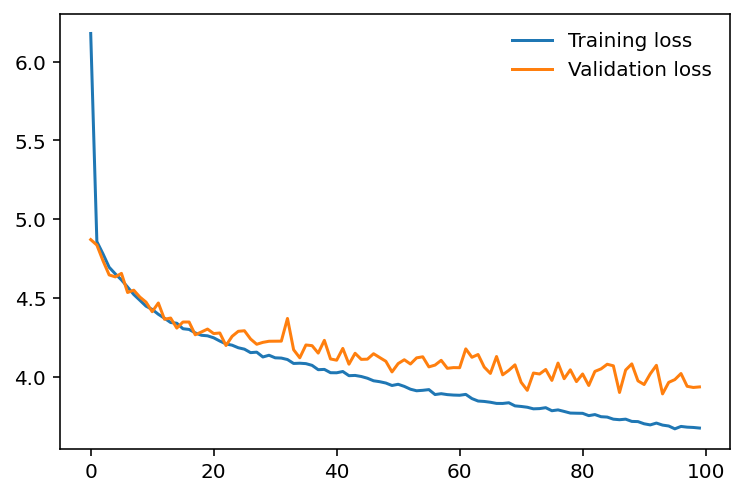

Test Loss: 3.976754

Test Accuracy: 10% (84/836)




In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import torch.optim as optim
from PIL import ImageFile
import matplotlib.pyplot as plt
import datetime
import torch.nn as nn
import torch.nn.functional as F
ImageFile.LOAD_TRUNCATED_IMAGES = True


mixed_transforms = torchvision.transforms.Compose([
    ImgAugTransform(),
    lambda x: PIL.Image.fromarray(x),
    torchvision.transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([transforms.Resize(size=258),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])



train_data = datasets.ImageFolder('dog_images/train', transform=mixed_transforms)
valid_data = datasets.ImageFolder('dog_images/valid', transform=valid_transforms)
test_data = datasets.ImageFolder('dog_images/test', transform=valid_transforms)


trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=0)

loaders_scratch = {'train' : trainloader, 'valid' : validloader, 'test' : testloader}


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.batchn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.batchn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.batchn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.batchn4 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 14 * 14, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 133)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x):
        x = self.pool(F.relu(self.batchn1(self.conv1(x))))
        x = self.pool(F.relu(self.batchn2(self.conv2(x))))
        x = self.pool(F.relu(self.batchn3(self.conv3(x))))
        x = self.pool(F.relu(self.batchn4(self.conv4(x))))
        #Sprint(x.size())
        x = x.view(-1, 128 * 14 * 14)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


model_scratch = Net()
print (model_scratch)

use_cuda = torch.cuda.is_available()
if use_cuda:
    model_scratch.cuda()

learning_rates = [
                 #0.001
                 #0.0015,
                 0.0025,
                 #0.0035

                 ]

optimizers = [
                optim.Adagrad,
                #optim.Adam
            ]


def test(loaders, model, criterion, use_cuda):
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
    print('Test Loss: {:.6f}'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)\n\n' % (
        100. * correct / total, correct, total))

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

def reboot(loaders, model, criterion):
    del loaders
    del model
    del criterion
    torch.cuda.empty_cache()
    
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
    validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True, num_workers=0)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=0)
    
    new_model = Net()
    new_model.apply(weights_init)
    new_model.cuda()
    
    new_criterion = criterion_scratch = nn.CrossEntropyLoss()
    
    return {'train' : trainloader, 'valid' : validloader, 'test' : testloader}, new_model, new_criterion

current_optimizer = ''
model_scratch = ''
criterion_scratch = ''
for optimizer in optimizers:
    for lr in learning_rates:
        loaders_scratch, model_scratch, criterion_scratch = reboot(loaders_scratch, model_scratch, criterion_scratch)
        del current_optimizer
        current_optimizer = optimizer(model_scratch.parameters(), lr)
        
        print(current_optimizer)
        model, train_losses, valid_losses, time_spent = train(100, loaders_scratch, 
                                                              model_scratch, 
                                                              current_optimizer, 
                                                              criterion_scratch, 
                                                              use_cuda, 
                                                              'model_scratch.pt',
                                                              verbose=True)
        
        print("time spent: ", str(datetime.timedelta(seconds=time_spent)))
        
        min_train_loss = float(min(train_losses))
        min_valid_loss = float(min(valid_losses))
        
        print("Minimum trainig loss: ", min_train_loss)
        print("Minimum validation loss: ", min_valid_loss)

        plt.plot(train_losses, label='Training loss')
        plt.plot(valid_losses, label='Validation loss')
        
        plt.legend(frameon=False)
        plt.show()
       
        model_scratch.load_state_dict(torch.load('model_scratch.pt'))
        test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)
        


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import torch.optim as optim
from PIL import ImageFile
import matplotlib.pyplot as plt
import datetime
import torch.nn as nn
import torch.nn.functional as F
ImageFile.LOAD_TRUNCATED_IMAGES = True


mixed_transforms = torchvision.transforms.Compose([
    ImgAugTransform(),
    lambda x: PIL.Image.fromarray(x),
    torchvision.transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([transforms.Resize(size=258),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])



train_data = datasets.ImageFolder('dog_images/train', transform=mixed_transforms)
valid_data = datasets.ImageFolder('dog_images/valid', transform=valid_transforms)
test_data = datasets.ImageFolder('dog_images/test', transform=valid_transforms)


trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=0)

loaders_scratch = {'train' : trainloader, 'valid' : validloader, 'test' : testloader}


class Net_BN_Res(nn.Module,):
    def __init__(self, n_classes = 133, depth_1 = 32):
        super(Net_BN_Res, self).__init__()        
        # Keep track of things
        depth_2 = depth_1 * 2
        depth_3 = depth_2 * 2      
        # Max pooling layer
        self.pool = nn.MaxPool2d(2,2)
        # Conv set 1
        self.conv1_1 = nn.Conv2d(3,depth_1,3,stride = 1,padding = 1)
        self.conv1_2 = nn.Conv2d(depth_1,depth_1,3,stride = 1,padding = 1)
        self.bn1_1 = nn.BatchNorm2d(depth_1)
        self.bn1_2 = nn.BatchNorm2d(depth_1)
        # Conversion from depth_1 to depth_2
        self.conv1x1_2 = nn.Conv2d(depth_1,depth_2,1,stride = 1,padding = 0)
        # Conv set 2
        self.conv2_1 = nn.Conv2d(depth_2,depth_2,3,stride = 1,padding = 1)
        self.conv2_2 = nn.Conv2d(depth_2,depth_2,3,stride = 1,padding = 1)
        self.bn2_1 = nn.BatchNorm2d(depth_2)
        self.bn2_2 = nn.BatchNorm2d(depth_2)    
        # Conversion from depth_2 to depth_3
        self.conv1x1_3 = nn.Conv2d(depth_2,depth_3,1,stride = 1,padding = 0)        
        # Conv set 3
        self.conv3_1 = nn.Conv2d(depth_3,depth_3,3,stride = 1,padding = 1)
        self.conv3_2 = nn.Conv2d(depth_3,depth_3,3,stride = 1,padding = 1)
        self.bn3_1 = nn.BatchNorm2d(depth_3)
        self.bn3_2 = nn.BatchNorm2d(depth_3)
        # Output
        self.fc_out = nn.Linear(depth_3,n_classes)   
        # Initialize weights
        nn.init.kaiming_normal_(self.conv1_1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv1_2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2_1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2_2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv3_1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv3_2.weight, nonlinearity='relu') 
            
    def forward(self, x):
        # Conv 1
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = self.pool(x)
        out = self.conv1x1_2(x)
        # Conv 2
        x = F.relu(self.bn2_1(self.conv2_1(out)))
        x = self.bn2_2(self.conv2_2(x))
        x = F.relu(x + out)
        x = self.pool(x)        
        out = self.conv1x1_3(x)
        # Conv 3
        x = F.relu(self.bn3_1(self.conv3_1(out)))
        x = self.bn3_2(self.conv3_2(x))
        x = F.relu(x + out)
        x = self.pool(x)
        # First we fuse the height and width dimensions (2 and 3) 
        x = x.view(x.size(0),x.size(1),-1)        
        # And now max global pooling
        x = x.max(2)[0]
        # Output
        x = self.fc_out(x)
        return x


model_scratch = Net_BN_Res()
print (model_scratch)

use_cuda = torch.cuda.is_available()
if use_cuda:
    model_scratch.cuda()

learning_rates = [
                 #0.001
                 0.0015,
                 #0.0025,
                 #0.0035

                 ]

optimizers = [
                #optim.Adagrad,
                optim.Adam
            ]


def test(loaders, model, criterion, use_cuda):
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
    print('Test Loss: {:.6f}'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)\n\n' % (
        100. * correct / total, correct, total))

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

def reboot(loaders, model, criterion):
    del loaders
    del model
    del criterion
    torch.cuda.empty_cache()
    
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
    validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True, num_workers=4)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)
    
    new_model = Net_BN_Res()
    new_model.apply(weights_init)
    new_model.cuda()
    
    new_criterion = criterion_scratch = nn.CrossEntropyLoss()
    
    return {'train' : trainloader, 'valid' : validloader, 'test' : testloader}, new_model, new_criterion

current_optimizer = ''
model_scratch = ''
criterion_scratch = ''
for optimizer in optimizers:
    for lr in learning_rates:
        loaders_scratch, model_scratch, criterion_scratch = reboot(loaders_scratch, model_scratch, criterion_scratch)
        del current_optimizer
        current_optimizer = optimizer(model_scratch.parameters(), lr)
        
        print(current_optimizer)
        model, train_losses, valid_losses, time_spent = train(100, loaders_scratch, 
                                                              model_scratch, 
                                                              current_optimizer, 
                                                              criterion_scratch, 
                                                              use_cuda, 
                                                              'model_scratch.pt',
                                                              verbose=True)
        
        print("time spent: ", str(datetime.timedelta(seconds=time_spent)))
        
        min_train_loss = float(min(train_losses))
        min_valid_loss = float(min(valid_losses))
        
        print("Minimum trainig loss: ", min_train_loss)
        print("Minimum validation loss: ", min_valid_loss)

        plt.plot(train_losses, label='Training loss')
        plt.plot(valid_losses, label='Validation loss')
        
        plt.legend(frameon=False)
        plt.show()
       
        model_scratch.load_state_dict(torch.load('model_scratch.pt'))
        test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)
        


Net_BN_Res(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1x1_2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv2_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1x1_3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  (conv3_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2):

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.
  after removing the cwd from sys.path.


RuntimeError: ignored

In [0]:
       
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)
        

Test Loss: 3.301101

Test Accuracy: 25% (211/836)




In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import torch.optim as optim
from PIL import ImageFile
import matplotlib.pyplot as plt
import datetime
import torch.nn as nn
import torch.nn.functional as F
ImageFile.LOAD_TRUNCATED_IMAGES = True


mixed_transforms = torchvision.transforms.Compose([
    ImgAugTransform(),
    lambda x: PIL.Image.fromarray(x),
    torchvision.transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([transforms.Resize(size=258),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])



train_data = datasets.ImageFolder('dog_images/train', transform=mixed_transforms)
valid_data = datasets.ImageFolder('dog_images/valid', transform=valid_transforms)
test_data = datasets.ImageFolder('dog_images/test', transform=valid_transforms)


trainloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True, num_workers=0)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=16, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False, num_workers=0)

loaders_scratch = {'train' : trainloader, 'valid' : validloader, 'test' : testloader}

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=133):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(25088, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):

          out = F.relu(self.bn1(self.conv1(x)))
          out = self.layer1(out)
          out = self.layer2(out)
          out = self.layer3(out)
          out = self.layer4(out)
          out = F.avg_pool2d(out, 4)
          out = out.view(out.size(0), -1)
          out = self.linear(out)


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

model_scratch = ResNet18()
print (model_scratch)

use_cuda = torch.cuda.is_available()
if use_cuda:
    model_scratch.cuda()

learning_rates = [
                 #0.001
                 0.0015,
                 0.0025,
                 #0.0035

                 ]

optimizers = [
                optim.Adagrad,
                optim.Adam
            ]


def test(loaders, model, criterion, use_cuda):
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
    print('Test Loss: {:.6f}'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)\n\n' % (
        100. * correct / total, correct, total))

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)



def reboot(loaders, model, criterion):
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
      print('and then re-execute this cell.')
    else:
      print(gpu_info)    

    del loaders
    del model
    del criterion
    torch.cuda.empty_cache()
    
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
    validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True, num_workers=4)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)
    
    new_model = ResNet18()
    new_model.apply(weights_init)
    new_model.cuda()
    
    new_criterion = criterion_scratch = nn.CrossEntropyLoss()
    
    return {'train' : trainloader, 'valid' : validloader, 'test' : testloader}, new_model, new_criterion

current_optimizer = ''
model_scratch = ResNet18()
criterion_scratch = ''
for optimizer in optimizers:
    for lr in learning_rates:
        loaders_scratch, model_scratch, criterion_scratch = reboot(loaders_scratch, model_scratch, criterion_scratch)
        del current_optimizer
        current_optimizer = optimizer(model_scratch.parameters(), lr)
        
        print(current_optimizer)
        model, train_losses, valid_losses, time_spent = train(10, loaders_scratch, 
                                                              model_scratch, 
                                                              current_optimizer, 
                                                              criterion_scratch, 
                                                              use_cuda, 
                                                              'model_scratch.pt',
                                                              verbose=True)
        
        print("time spent: ", str(datetime.timedelta(seconds=time_spent)))
        
        min_train_loss = float(min(train_losses))
        min_valid_loss = float(min(valid_losses))
        
        print("Minimum trainig loss: ", min_train_loss)
        print("Minimum validation loss: ", min_valid_loss)

        plt.plot(train_losses, label='Training loss')
        plt.plot(valid_losses, label='Validation loss')
        
        plt.legend(frameon=False)
        plt.show()
       
        model_scratch.load_state_dict(torch.load('model_scratch.pt'))
        test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)
        


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

AttributeError: ignored

In [0]:

import torchvision.models as models
model_transfer = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Mar 30 12:36:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    32W / 250W |  16263MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!ps aux | grep python

root          23  0.1  0.5 520520 138420 ?       Sl   11:36   0:03 /usr/bin/python2 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --MappingKernelManager.root_dir="/content"
root         139  0.6  9.9 34592076 2660864 ?    Ssl  11:37   0:21 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-31e7b2a5-f518-4e97-ab36-337e63fa2d74.json
root         185  0.1  1.2 2601640 340788 ?      Sl   11:38   0:06 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-31e7b2a5-f518-4e97-ab36-337e63fa2d74.json
root         186  0.1  1.3 2622420 362372 ?      Sl   11:38   0:05 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-31e7b2a5-f518-4e97-ab36-337e63fa2d74.json
root         187  0.1  1.3 2612192 349620 ?      Sl   11:38   0:04 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-31e7b2a5-f518-4e97-ab36-337e63fa2d74.json
root